In [ ]:
!pip install tensorflow==2.4.1 opencv-python mediapipe sklearn matplotlib

In [113]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [114]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [115]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)#color conversion bgr t0 rgb
    image.flags.writeable = False #image is no longer writeable
    results = model.process(image) #make prediction
    image.flags.writeable = True # image is now writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #color conversion rgb to bgr
    return image,results

In [117]:
def draw_styled_landmarks(image,results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             )
    
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2)
                             )
      
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2)
                             )
    
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2)
                             )
                

In [ ]:
cap = cv2.VideoCapture(0)
#access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        #read feed
        ret,frame = cap.read()
        
        #make predictions
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        
        #draw landmarks
        draw_styled_landmarks(image,results)
        
        #show to screen
        cv2.imshow('action',image)
        
        #break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [ ]:
len(results.pose_landmarks.landmark)

In [ ]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [ ]:
pose

In [ ]:
pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [ ]:
face

In [ ]:
pose

In [ ]:
lh

In [ ]:
rh

In [118]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])


In [ ]:
extract_keypoints(results).shape

In [119]:
#path for exported data, numpy array
DATA_PATH = os.path.join('MP_data')

#actions that we try to detect
actions = np.array(['hello','thankyou','iloveyou'])

#thirty videos worth of data
no_sequences = 30

#videos are going to be thirty frames in length
sequence_length = 30

In [120]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [121]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [122]:
label_map = {label:num for num,label in enumerate(actions)}

In [123]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [124]:
sequences,labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [125]:
os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(12))

'MP_data/iloveyou/29/12.npy'

In [ ]:
np.array(sequences).shape

In [ ]:
np.array(labels).shape

In [126]:
X = np.array(sequences)

In [127]:
y = to_categorical(labels).astype(int)

In [128]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [131]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [132]:
model.compile(optimizer = 'Adam',loss = 'categorical_Crossentropy',metrics = ['categorical_accuracy'])

In [133]:
model.load_weights('action.h5')

In [134]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [135]:
yhat = model.predict(X_test)

In [136]:
ytrue = np.argmax(y_test,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()

In [137]:
yhat

[0, 0, 1, 1, 2]

In [138]:
ytrue

[0, 0, 1, 1, 2]

In [139]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]])

In [140]:
accuracy_score(ytrue,yhat)

1.0

In [141]:
from scipy import stats


In [142]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

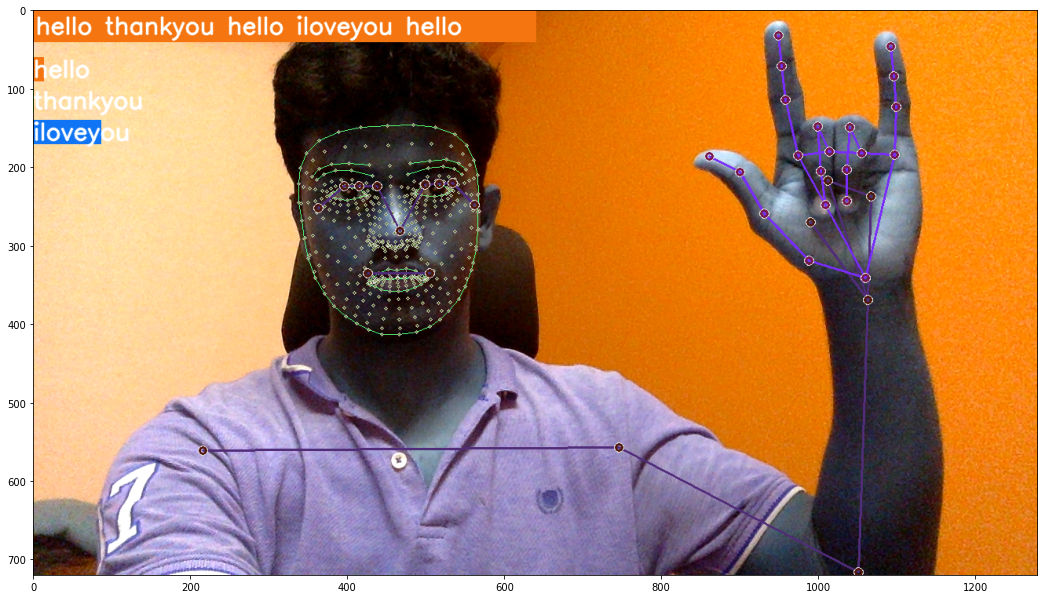

In [112]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()